# **Preprocessing Demo**  


> Estimated reading time: 45-60 minutes
>
> Author: Shirley Zhang
> 
> Date: June 2023


Source Code: 
- [`/src/Preprocessing/main.py`](../src/Preprocessing/main.py)
- [`/src/Preprocessing/preprocess.py`](../src/Preprocessing/preprocess.py)
- [`/src/Preprocessing/utils.py`](../src/Preprocessing/utils.py)


Documentation: 
- [`/docs/guides/Preprocessing/main.md`](../docs/guides/Preprocessing/main.md)
- [`/docs/guides/Preprocessing/preprocess.md`](../docs/guides/Preprocessing/preprocess.md)
- [`/docs/guides/Preprocessing/utils.md`](../docs/guides/Preprocessing/utils.md)

## **Introduction**

<div class="alert alert-block alert-info">

#### **Background:**

Raw data from the IsoGSM climate model used in this project come in a netCDF file. The data is homogeneous (uniformly gridded across space and time), but still require preprocessing before it can be fed into machine learning models. It is important to identify steps to clean the data as they can easily improve the performance of the models. For this project, the steps we identified and chose to perform on the IsoGSM dataset are the following: 

1. Split full dataset into training, validation, and test sets
2. Select the variables of interest 
3. Change the latitude/longitude dimensions for `hgtprs` (geopotential height)
4. Deseasonalize the data
5. Add new features including polar coordinates, months, and years
6. Interpolate missing values (i.e. NaN entries)
7. Scale variables

A more descriptive explanation (with rationale behind choices) of each step is shown here: [workflow_summary.md](../docs/workflow_summary.md).

This notebook shows how we implemented the preprocessing steps using code from `src/`. The majority of the steps process the data in an xarray format, and the final preprocessed data is saved back into netCDF files. Table 1 summarizes the variable names from the original IsoGSM netCDF file, the names of additional features added (step 4), and the names of the final preprocessed variables used in the machine learning (ML) models. 

**Table 1. Original, Added, and Preprocessed Variables for the IsoGSM Climate Model.**

| Original | Added features | Final preprocessed | Type | Final preprocessed description | 
|---|---|---|---|---|
|`d18O_pr` | --- | `scaled_deseas_d18O_pr` | Input | Scaled and deseasonalized $\delta^{18}O$ of precipication (i.e. scaled anomalies) |
| `hgtprs` | --- | `scaled_deseas_hgtprs` | Output | Scaled and deseasonalized geopotential height (i.e. scaled anomalies) |
| `pratesfc` | --- | `scaled_deseas_pratesfc` | Output | Scaled and deseasonalized precipication (i.e. scaled anomalies) |
| `tmp2m` | --- | `scaled_deseas_tmp2m` | Output | Scaled and deseasonalized temperature (i.e. scaled anomalies) |
| --- | `E` | `scaled_E` | Input | Scaled Easting Coordinate (Universal Polar Stereographic (UPS) projection) | 
| --- | `N` | `scaled_N` | Input | Scaled Northing Coordinate (Universal Polar Stereographic (UPS) projection) | 
| --- | `dist_to_coast` | `scaled_dist_to_coast` | Input | Scaled distance to the coast of Antarctica | 
| --- | `oro` | `scaled_oro` | Input | Scaled orography (a measure of the height of the surface) | 
| --- | `landsfc` | `landsfc` | Input | The land sea mask as a boolean (1 = land, 0 = sea) (no additional preprocessing performed) | 
| --- | `month` | `month` | Input | The month as a float (e.g. January = 1.0) (no additional preprocessing performed) | 
| --- | `year` | `year | Input | The year as a float (e.g. 2020 = 2020.0) (no additional preprocessing performed) | 

Preprocessing requires iteration and improvement. The steps we performed for this project are by no means perfect, and could be an area of more exploration for future members of this project. 

#### **Implementation:**

There are three Python scripts for the Preprocessing module: 
1. [`/src/Preprocessing/utils.py`](../src/Preprocessing/utils.py) 
    - Contains all of the functions and classes used for preprocessing 
2. [`/src/Preprocessing/preprocess.py`](../src/Preprocessing/preprocess.py)
    - A script which calls each of the functions in `utils.py` to preprocess **one** raw data file
    - The raw data file will be preprocessed different based on whether it is training, validation, or test data 
3. [`/src/Preprocessing/main.py`](../src/Preprocessing/main.py)
    - A script which firstly splits the entire IsoGSM dataset into training, validation, and test sets, and then calls the `preprocess.py` script to separately preprocess each file
    - This can be run from the command line to run the entire preprocessing pipeline ([instructions here](...))

The motivation for separating `main.py` and `preprocess.py` is to ensure the training, validation, and test sets are preprocessed separately to avoid breaking the Golden Rule of Machine Learning ("the test data should not influence the training data/training the model"). 

#### **Notebook Overview:** 

Under **Demo**, this notebook replicates everything that is done in the three preprocessing scripts (as mentioned in **Implementation**). The yellow box below shows the sections of the Demo. 

- Sections 1, 2, and 10 (load raw data, split, and save final preprocessed data) covers what is done within `main.py`
- Sections 3 - 9 replicate what is done within `preprocess.py`
    - Sections 4 - 9 use functions that are contained within `utils.py` 

#### **Purpose:** 

The purpose of this notebook is to: 
- Demonstrate the usage of the functions in `utils.py`.
- Give the reader an understanding of what is happening in preprocessing by showing the updates to the raw data after each step.
- Duplicate what is done if you were to run preprocessing through the command line ([instructions here](...)), and generate preprocessed outputs.
    - If you were to run the notebook top to bottom, you should be able to generate the same preprocessed training, validation, and test files used in the actual project.

</div>

## **Demo**

<div class="alert alert-block alert-warning">

**Sections:**
1. Load raw data
2. Split full dataset into training, validation, and test
3. Select the variables of interest
4. Shift geopotential height
5. Check and/or transpose dimensions
6. Deseasonalize variables
7. Add spatial (and temporal) variables
8. Interpolate missing data
9. Scale variables
10. Save preprocessed data 
</div>

#### ⚠️ Before running the demo, ensure the following conditions are met: ⚠️

- [ ] You have cloned the MDS_Antarctica repository and installed the `slipp.yml` environment ([instructions here](https://github.com/SLIPP-isotopes/MDS_Antarctica/tree/main#1-installation))
- [ ] This notebook is using the kernel **Python [conda env:slipp]** 
- [ ] This notebook is under the `MDS_Antarctica/notebooks/` directory
- [ ] The `MDS_Antarctica/data/IsoGSM/` directory contains the files `Total.IsoGSM.ERA5.monmean.nc`, `IsoGSM_land_sea_mask.nc`, `IsoGSM_orogrd.nc`

In [1]:
# Move the current working directory to the top level directory
import os
if os.getcwd().split('/')[-1] == 'notebooks' or os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('../') 

In [2]:
# Import Preprocessing.utils
from src.Preprocessing.utils import *

# Import other libraries for this notebook 
import matplotlib.pyplot as plt # for plotting 
import pandas as pd 
from IPython.display import Markdown # for displaying titles 

### 1. Load raw data

**In general:**

The input to preprocessing pipeline is an xarray dataset of raw data from a climate model. Thus, you must firstly have a netCDF file of raw data saved on your local computer. You must then load it as an xarray dataset using the `xarray` package (`xr.open_dataset()`). 

---

**This demo:**

This demo uses 42 years of raw data from the IsoGSM dataset, along with geographic data for Antarctica. Before running the following cell, ensure that you have the following files saved under the `MDS_Antarctica/data/IsoGSM/` folder: 
- `Total.IsoGSM.ERA5.monmean.nc`
- `IsoGSM_land_sea_mask.nc`
- `IsoGSM_orogrd.nc`

To get these files, you can either: 
1. Transfer/download the raw data from sockeye if you have access ([instructions here](../README.md#2-downloading-data))
3. Get the data files from a previous member of the project

In [3]:
# Load raw data as xarray datasets

############ ENSURE THE PATH BELOW POINTS TO THE RAW DATA 
data_path = 'data/IsoGSM/' 
#########################################################

raw_ds = xr.open_dataset(data_path + 'Total.IsoGSM.ERA5.monmean.nc') 
land_sea_ds = xr.open_dataset(data_path + 'IsoGSM_land_sea_mask.nc') 
orogrd_ds = xr.open_dataset(data_path + 'IsoGSM_orogrd.nc') 

**Visual inspection:**

The following code cells show that:
1. `raw_ds` has 7 dimensions (time, bnds, longitude, latitude, longitude_2, latitude_2, and levels)
2. The dimension "time" has 504 unique values
    - The values range from 1979-01-16 to 2020-12-16
    - Each value is a different month 
    - The type is "datetime64[ns]"
3. The dimension "longitude" has 192 unique values
    - The values range from 0 to 358.125
    - The type is "float64"
    - The units are "degrees_east"
3. The dimension "latitude" has 94 unique values
    - The values range from -88.542 to 88.542
    - The type is "float64"
    - The units are "degrees_north"

In [4]:
# Show 7 dimensions of raw_ds
raw_ds.dims

Frozen({'time': 504, 'bnds': 2, 'longitude': 192, 'latitude': 94, 'longitude_2': 144, 'latitude_2': 73, 'levels': 1})

In [5]:
# Show information about the dimension "time"
raw_ds.time

<xarray.DataArray 'time' (time: 504)>
array(['1979-01-16T09:00:00.000000000', '1979-02-14T21:00:00.000000000',
       '1979-03-16T09:00:00.000000000', ..., '2020-10-16T09:00:00.000000000',
       '2020-11-15T21:00:00.000000000', '2020-12-16T09:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-16T09:00:00 ... 2020-12-16T09:00:00
Attributes:
    standard_name:  time
    bounds:         time_bnds
    axis:           T

In [6]:
# Show information about the dimension "longitude"
raw_ds.longitude

<xarray.DataArray 'longitude' (longitude: 192)>
array([  0.   ,   1.875,   3.75 ,   5.625,   7.5  ,   9.375,  11.25 ,  13.125,
        15.   ,  16.875,  18.75 ,  20.625,  22.5  ,  24.375,  26.25 ,  28.125,
        30.   ,  31.875,  33.75 ,  35.625,  37.5  ,  39.375,  41.25 ,  43.125,
        45.   ,  46.875,  48.75 ,  50.625,  52.5  ,  54.375,  56.25 ,  58.125,
        60.   ,  61.875,  63.75 ,  65.625,  67.5  ,  69.375,  71.25 ,  73.125,
        75.   ,  76.875,  78.75 ,  80.625,  82.5  ,  84.375,  86.25 ,  88.125,
        90.   ,  91.875,  93.75 ,  95.625,  97.5  ,  99.375, 101.25 , 103.125,
       105.   , 106.875, 108.75 , 110.625, 112.5  , 114.375, 116.25 , 118.125,
       120.   , 121.875, 123.75 , 125.625, 127.5  , 129.375, 131.25 , 133.125,
       135.   , 136.875, 138.75 , 140.625, 142.5  , 144.375, 146.25 , 148.125,
       150.   , 151.875, 153.75 , 155.625, 157.5  , 159.375, 161.25 , 163.125,
       165.   , 166.875, 168.75 , 170.625, 172.5  , 174.375, 176.25 , 178.125,
       180.   , 181.875, 183.75 , 185.625, 187.5  , 189.375, 191.25 , 193.125,
       195.   , 196.875, 198.75 , 200.625, 202.5  , 204.375, 206.25 , 208.125,
       210.   , 211.875, 213.75 , 215.625, 217.5  , 219.375, 221.25 , 223.125,
       225.   , 226.875, 228.75 , 230.625, 232.5  , 234.375, 236.25 , 238.125,
       240.   , 241.875, 243.75 , 245.625, 247.5  , 249.375, 251.25 , 253.125,
       255.   , 256.875, 258.75 , 260.625, 262.5  , 264.375, 266.25 , 268.125,
       270.   , 271.875, 273.75 , 275.625, 277.5  , 279.375, 281.25 , 283.125,
       285.   , 286.875, 288.75 , 290.625, 292.5  , 294.375, 296.25 , 298.125,
       300.   , 301.875, 303.75 , 305.625, 307.5  , 309.375, 311.25 , 313.125,
       315.   , 316.875, 318.75 , 320.625, 322.5  , 324.375, 326.25 , 328.125,
       330.   , 331.875, 333.75 , 335.625, 337.5  , 339.375, 341.25 , 343.125,
       345.   , 346.875, 348.75 , 350.625, 352.5  , 354.375, 356.25 , 358.125])
Coordinates:
  * longitude  (longitude) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X

In [7]:
# Show information about the dimension "latitude"
raw_ds.latitude

<xarray.DataArray 'latitude' (latitude: 94)>
array([-88.542   , -86.653   , -84.752998, -82.850998, -80.946999, -79.042999,
       -77.139   , -75.235001, -73.331001, -71.426003, -69.522003, -67.616997,
       -65.712997, -63.807999, -61.903   , -59.999001, -58.094002, -56.188999,
       -54.285   , -52.380001, -50.474998, -48.570999, -46.666   , -44.761002,
       -42.855999, -40.952   , -39.047001, -37.141998, -35.237999, -33.333   ,
       -31.427999, -29.523001, -27.618999, -25.714001, -23.809   , -21.903999,
       -20.      , -18.094999, -16.190001, -14.286   , -12.381   , -10.476   ,
        -8.571   ,  -6.667   ,  -4.762   ,  -2.857   ,  -0.952   ,   0.952   ,
         2.857   ,   4.762   ,   6.667   ,   8.571   ,  10.476   ,  12.381   ,
        14.286   ,  16.190001,  18.094999,  20.      ,  21.903999,  23.809   ,
        25.714001,  27.618999,  29.523001,  31.427999,  33.333   ,  35.237999,
        37.141998,  39.047001,  40.952   ,  42.855999,  44.761002,  46.666   ,
        48.570999,  50.474998,  52.380001,  54.285   ,  56.188999,  58.094002,
        59.999001,  61.903   ,  63.807999,  65.712997,  67.616997,  69.522003,
        71.426003,  73.331001,  75.235001,  77.139   ,  79.042999,  80.946999,
        82.850998,  84.752998,  86.653   ,  88.542   ])
Coordinates:
  * latitude  (latitude) float64 -88.54 -86.65 -84.75 ... 84.75 86.65 88.54
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    axis:           Y

When looking at the entire `raw_ds` dataset, we see that: 
1. `raw_ds` has 17 data variables 
    - All variables (except "time_bnds") are of type "float32" (open the "Data variables: 17" drop down)
    - All variables (except "time_bnds" and "hgtprs") have 3 dimensions: "time", "latitude" and "longitude"
    - All variables (except "time_bnds") have 9096192 values (click on the stacked circle icon for a variable on the right)
3. The variable `hgtprs` (geopotential height) is one we are interested in, however it has:
    - The dimension "levels" which only has one unique value - we will deal with this in "3. Select the variables we want"
    - The dimensions "latitude_2" and "longitude_2" which are different from the coordinates of other data variables - we will deal with this in "4. Shift geopotential height""

In [8]:
# Show entire dataset
raw_ds

<xarray.Dataset>
Dimensions:      (time: 504, bnds: 2, longitude: 192, latitude: 94,
                  longitude_2: 144, latitude_2: 73, levels: 1)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-16T09:00:00 ... 2020-12-16T09:...
  * longitude    (longitude) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * latitude     (latitude) float64 -88.54 -86.65 -84.75 ... 84.75 86.65 88.54
  * longitude_2  (longitude_2) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * latitude_2   (latitude_2) float64 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
  * levels       (levels) float64 500.0
Dimensions without coordinates: bnds
Data variables: (12/17)
    time_bnds    (time, bnds) datetime64[ns] ...
    d18O_ev      (time, latitude, longitude) float32 ...
    d18O_pr      (time, latitude, longitude) float32 ...
    d18O_sp      (time, latitude, longitude) float32 ...
    dD_ev        (time, latitude, longitude) float32 ...
    dD_pr        (time, latitude, longitude) float32 ...
    ...           ...
    lhtflsfc     (time, latitude, longitude) float32 ...
    prate1sfc    (time, latitude, longitude) float32 ...
    prate2sfc    (time, latitude, longitude) float32 ...
    pratesfc     (time, latitude, longitude) float32 ...
    srweqsfc     (time, latitude, longitude) float32 ...
    tmp2m        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  COARDS
    history:      Thu Jul 07 17:06:32 2022: cdo monmean Total.IsoGSM.ERA5.dai...
    calendar:     standard
    comments:     file created by grads using lats4d available from http://da...
    model:        geos/das
    center:       gsfc
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

### 2. Split full dataset into training, validation, and test 

**In general:**

Before beginning preprocessing, the full raw dataset must be split into training, validation, and test sets. Then, preprocessing is performed on each set seperately to prevent breaking the Golden Rule of Machine Learning ("the test data should not influence the training data/training the model"). 

To do this, first determine how many years are in your dataset. Then, decide the time range you want for each split (each split should include entire years, i.e. from January to December). 

---

**This demo:**

The following code cells show how: for the IsoGSM dataset, we split the full 42 years into 26 years of training, 8 years of validation, and 8 years of test as seen in the image below: 

![train_valid_test_split.png](../img/train_valid_test_split.png)

**Figure 1. Train, validation, and test split time ranges for the IsoGSM dataset.**

We also reduce the range in the "latitude" dimension for the data to only encompass Antarctica. 
- We only select latitude values between -90 and -60
- This corresponds to -88.542 to -61.903 in the IsoGSM dataset

In [9]:
# Define the time slices for each split 
TEST_YEAR_RANGE = slice("1979-01-01", "1986-12-31") # First 8 years of data
VALID_YEAR_RANGE = slice("1987-01-01", "1994-12-31") # Next 8 years of data (after test data)
TRAIN_YEAR_RANGE = slice("1995-01-01", "2020-12-31") # Remaining 26 years of (after test & valid data)

In [10]:
# Define the latitude slice for Antarctica 
LAT_RANGE = slice(-90, -60)

In [11]:
# Create the splits of data by selecting slices 
raw_train = raw_ds.sel(time=TRAIN_YEAR_RANGE, latitude=LAT_RANGE)
raw_valid = raw_ds.sel(time=VALID_YEAR_RANGE, latitude=LAT_RANGE)
raw_test = raw_ds.sel(time=TEST_YEAR_RANGE, latitude=LAT_RANGE)

**Visual inspection:**

The following code cells show the time ranges of `raw_train`, `raw_valid`, and `raw_test`, as well as the latitude range of `raw_train`. 

In [12]:
# Time range of raw_train
print(raw_train.time[0].values)
print(raw_train.time[-1].values)

1995-01-16T09:00:00.000000000
2020-12-16T09:00:00.000000000


In [13]:
# Time range of raw_valid
print(raw_valid.time[0].values)
print(raw_valid.time[-1].values)

1987-01-16T09:00:00.000000000
1994-12-16T09:00:00.000000000


In [14]:
# Time range of raw_test
print(raw_test.time[0].values)
print(raw_test.time[-1].values)

1979-01-16T09:00:00.000000000
1986-12-16T09:00:00.000000000


In [15]:
# Latitude range of raw_train
print(raw_train.latitude[0].values)
print(raw_train.latitude[-1].values)

-88.54199981689453
-61.90299987792969


### 3. Select the variables of interest

**In general:**

Selecting only the variables we will be using in our ML models helps to reduce the size of the data and avoid unnecessary computations. For this project, we need: 

1. A measure of $\delta^{18}O$ (input)
2. A measure of geopotential height (output)
3. A measure of precipitation (output)
4. A measure of temperature (output)

--- 

**For this demo:**

For the IsoGSM dataset, we selected the following variables: 

**Table 2. Selected Variables from IsoGSM.**

| Variable | Description | Units | Type | 
|---|---|---|---|
| `d18O_pr` | $\delta^{18}O$ in surface precipication | Per mil | Input variable | 
| `hgtprs` | Geopotential height | [gpm] (geopotential meters) | Output variable |
| `pratesfc` | Surface precipitation rate | [kg/m^2/s] | Output variable |
| `tmp2m` | Temperature at 2 m above the surface of the Earth| K (kelvin) | Output variable |

Out of these 4 variables, only `hgtprs` has the dimension "levels". We drop this level so that the dimensions are consistent. Since there is only one unique value in "levels", we can use the `ds.squeeze()` ([more info](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.squeeze.html)) method. 

We do these steps separately for the train, valid, and test splits. 

In [16]:
# TRAIN 
# Select only the variables we want
preprocessed_train_step3 = raw_train.copy() 
preprocessed_train_step3 = preprocessed_train_step3[["d18O_pr", "hgtprs", "pratesfc", "tmp2m"]] 

# Drop the levels dimension 
preprocessed_train_step3 = preprocessed_train_step3.squeeze("levels").drop("levels") 

In [17]:
# REPEAT FOR VALID AND TEST 
preprocessed_valid_step3 = raw_valid.copy() 
preprocessed_valid_step3 = preprocessed_valid_step3[["d18O_pr", "hgtprs", "pratesfc", "tmp2m"]] 
preprocessed_valid_step3 = preprocessed_valid_step3.squeeze("levels").drop("levels")

preprocessed_test_step3 = raw_test.copy() 
preprocessed_test_step3 = preprocessed_test_step3[["d18O_pr", "hgtprs", "pratesfc", "tmp2m"]] 
preprocessed_test_step3 = preprocessed_test_step3.squeeze("levels").drop("levels")

**Visual inspection:** 

The following code cell shows that the training dataset (`preprocessed_train_step3`) only has 4 data variables, and no "levels" dimension. This is similar for the validation (`preprocessed_valid_step3`) and test (`preprocessed_test_step3`) datasets.

In [18]:
# Show the training dataset 
preprocessed_train_step3

<xarray.Dataset>
Dimensions:      (time: 312, latitude: 15, longitude: 192, latitude_2: 73,
                  longitude_2: 144)
Coordinates:
  * time         (time) datetime64[ns] 1995-01-16T09:00:00 ... 2020-12-16T09:...
  * longitude    (longitude) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * latitude     (latitude) float64 -88.54 -86.65 -84.75 ... -65.71 -63.81 -61.9
  * longitude_2  (longitude_2) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * latitude_2   (latitude_2) float64 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
Data variables:
    d18O_pr      (time, latitude, longitude) float32 ...
    hgtprs       (time, latitude_2, longitude_2) float32 ...
    pratesfc     (time, latitude, longitude) float32 ...
    tmp2m        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  COARDS
    history:      Thu Jul 07 17:06:32 2022: cdo monmean Total.IsoGSM.ERA5.dai...
    calendar:     standard
    comments:     file created by grads using lats4d available from http://da...
    model:        geos/das
    center:       gsfc
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

### 4. Shift geopotential height 

**In general:**

This step calls the following function from `utils.py`:

**`combine_latlon_grids(ds)`**

- This function takes in a dataset that has the dimensions "latitude", "longitude", "latitude_2", and "longitude_2".

The function uses the xArray `Dataset.interp()` method to interpolate the `hgtprs` points onto the grid specified by the "latitude" and "longitude" dimensions based on their values in the existing "latitude_2" and "longitude_2" dimensions. Linear interpolation is used. We took care to account for the false boundary between longitudes 0 and 360 by doing this interpolation twice: 
- *South*: interpolate with the longitudes on a scale from 0 to 360, and
- *North*: interpolate with the longitudes on a scale from -180 to 180. (See [xarray Dataset.assign_coords for the example conversion](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.assign_coords.html))

We stitch the south half of *South* (latitudes 90 to 180) to the north half of *North* (latitudes -90 to 90) to return a complete picture which accounts for the circular nature of longitude lines.
    
Note that this interpolation would be more accurate using polar coordinates instead of latitude and longitudes, but we have not implemented this at the time, and the improvements are likely to be minimal since the grids are of similar density.
 
[Interpolating data](https://docs.xarray.dev/en/stable/user-guide/interpolation.html)

---

**For this demo:**

As mentioned in "1. Load raw data", the variable `hgtprs` (geopotential height) has different latitude and longitude dimensions (i.e. have a different grid) than the other data variables. In particular, `hgtprs` has: 
- `latitude_2`
- `longitude_2`

Whereas `d18O_pr`, `pratesfc`, and `tmp2m` have: 
- `latitude`
- `longitude`

Thus, we use the method `combine_latlon_grids()` to shift the dimensions for `hgtprs` to become `latitude` and `longitude`. 

We do these steps separately for the train, valid, and test splits. 

In [19]:
# TRAIN
# Shift latitude and longitude in geopotential height 
preprocessed_train_step4 = combine_latlon_grids(preprocessed_train_step3) 

In [20]:
# REPEAT FOR VALID AND TEST 
preprocessed_valid_step4 = combine_latlon_grids(preprocessed_valid_step3) 
preprocessed_test_step4 = combine_latlon_grids(preprocessed_test_step3) 

**Visual inspection:**

The following cells show that for the training dataset after step 4, there are only the dimensions "time", "longitude", and "latitude".

In [21]:
# Dimensions before
preprocessed_train_step3.dims

Frozen({'time': 312, 'latitude': 15, 'longitude': 192, 'latitude_2': 73, 'longitude_2': 144})

In [22]:
# Dimensions after
preprocessed_train_step4.dims

Frozen({'time': 312, 'longitude': 192, 'latitude': 15})

### 5. Check and/or transpose dimensions

**In general:**

The dimensions of the IsoGSM dataset are the following: (time, longitude, latitude). For some of the steps performed earlier, dimensions may have changed to become (time, latitude, longitude). There could be incorrect calculations going forward if dimensions are incorrectly ordered. Thus, this step ensures that all datasets have dimensions ordered as (time, latitude, longitude).

This step calls the following function from `utils.py`:

**`check_valid_xarray_input(ds)`**

- This function checks if the dataset passed (`ds`) has dimensions in the order (time, longitude, latitude).
    - If so, it will return the message "transpose lat/lon". 
- If the dataset passed has the correct order of dimensions (time, latitude, longitude):
    - It will return `True`.

--- 

**For this demo:**

The code cells below first call `check_valid_xarray_input()` to see if the dataset needs to have its dimensions switched. If so, the xarray function `ds.transpose()` ([more info](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.transpose.html)) is called to switch the dimensions. The function `check_valid_xarray_input()` is called again to ensure that the dimensions no longer need to be switched.

We do these steps separately for the train, valid, and test splits. 

In [23]:
# TRAIN 
# Check if dimensions are in the format (time, lon, lat)
input_check = check_valid_xarray_input(preprocessed_train_step4)
print(f'input_check: {input_check}')

# Forces the dimensions to be (time, lat, lon)
if input_check == "transpose lat/lon":
    preprocessed_train_step5 = preprocessed_train_step4.transpose(
        'time', 'latitude', 'longitude'
).to_array().to_dataset(dim='variable') 

# Check again 
input_check = check_valid_xarray_input(preprocessed_train_step5) 
print(f'input_check: {input_check}')

input_check: transpose lat/lon
input_check: True


In [24]:
# REPEAT FOR VALID AND TEST 
input_check = check_valid_xarray_input(preprocessed_valid_step4)
print(f'input_check: {input_check}')
if input_check == "transpose lat/lon":
    preprocessed_valid_step5 = preprocessed_valid_step4.transpose(
        'time', 'latitude', 'longitude'
).to_array().to_dataset(dim='variable') 
input_check = check_valid_xarray_input(preprocessed_valid_step5) 
print(f'input_check: {input_check}')

input_check = check_valid_xarray_input(preprocessed_test_step4)
print(f'input_check: {input_check}')
if input_check == "transpose lat/lon":
    preprocessed_test_step5 = preprocessed_test_step4.transpose(
        'time', 'latitude', 'longitude'
).to_array().to_dataset(dim='variable') 
input_check = check_valid_xarray_input(preprocessed_test_step5) 
print(f'input_check: {input_check}')

input_check: transpose lat/lon
input_check: True
input_check: transpose lat/lon
input_check: True


**Visual inspection:**

The following cells show that for the training dataset after step 5, the order of the dimensions are changed.

In [25]:
# Dimensions before
preprocessed_train_step4.dims

Frozen({'time': 312, 'longitude': 192, 'latitude': 15})

In [26]:
# Dimensions after
preprocessed_train_step5.dims

Frozen({'time': 312, 'latitude': 15, 'longitude': 192})

### 6. Deseasonalize 

**In general:**

When deseasonalizing our variables, we calculate the monthly "anomalies". These are values of the variables after subtracting the monthly mean over all years in the training data (for a specific latitude and longitude point):

$$v^{anomaly}_{lat,lon,month} = v_{lat,lon,month} - \bar{v}_{lat,lon,month} \,\,\,\,\,\,\,\text{(1)}$$

Where:

- $v_{lat,lon,month}$: one of the spatial-temporal variables $\delta^{18}O$, temperature, geopotential height, and precipication for a given latitude, longitude, and month
- $\bar{v}_{lat,lon,month}$: the mean of the variable for a specific latitude, longitude, and month over all years

This step calls the following function from `utils.py`:

**`deseasonalize(ds, years, train_ds=None)`**

- This function takes in a dataset (`ds`) with variables to be deseasonalized, the number of years in the dataset (`years`), and (optionally) the training dataset (`train_ds`).
    - `ds` should contain full years (i.e. January 2000 to December 2010) to ensure the means are calculated correctly, and that the output is tiled correctly. 
- The function then creates a list of all the data variables in `ds` that will be deseasonalized.

**If deseasonalizing the training data:**

Nothing should be passed to the argument `train_ds`.
- For each of the data variables, the function will:
    - Calculate the monthly mean per latitude and longitude point.
        - The result will be an array with 12 means (one for each month) for each latitude and longitude point.
    - Then, using `years`, the array with the monthly means is tiled (or repeated) for however many years were in `ds` so that the means can be subtracted from the original data.
    - After the monthly means are subtracted, the anomalies are saved as new data variables in the form `deseas_{var_name}`.
    - The tiled seasonal means are also saved as new data variables in the form `seasonal_means_{var_name}`.

**If deseasonalizing the validation or test data:**

The training data, with seasonal means already computed, should be passed to the argument `train_ds`. 
- For each of the data variables, the function will:
    - Take the seasonal means from the training dataset, and just get one year of it (12 values for each of the latitude and longitude points).
    - Since the validation and test datasets have different number of years than the training data, the seasonal means are re-tiled for however many years are in `ds`.
    - The monthly means are subtracted from the original data, and the anomalies are saved as new data variables in the form `deseas_{var_name}`.

--- 

**For this demo:**

The code cells below first calculate how many years are in the dataset (dividing the number of time points by 12, saving as an integer). Then, it calls `deseasonalize()` and saves the output as a new dataset. 

Note here that when deseasonalizing **validation** and **test data**, we must pass in the training data. 

In [27]:
# TRAIN 
# Calculate the number of years in the training dataset, save as integer
train_years = int(len(preprocessed_train_step5.time) / 12)

# Deseasonalize 
preprocessed_train_step6 = deseasonalize(preprocessed_train_step5, years=train_years)

In [28]:
# REPEAT FOR VALID AND TEST - PASS IN train_ds
valid_years = int(len(preprocessed_valid_step5.time) / 12)
preprocessed_valid_step6 = deseasonalize(preprocessed_valid_step5, years=valid_years, train_ds=preprocessed_train_step6)

test_years = int(len(preprocessed_test_step5.time) / 12)
preprocessed_test_step6 = deseasonalize(preprocessed_test_step5, years=test_years, train_ds=preprocessed_train_step6)

**Visual inspection:**

The following cells show that for the training data after step 6, new data variables for the deseasonalized data and calculated seasonal means are added.

In [29]:
# Data variables before 
preprocessed_train_step5.data_vars

Data variables:
    d18O_pr   (time, latitude, longitude) float64 -40.55 -40.55 ... -8.609
    hgtprs    (time, latitude, longitude) float64 5.023e+03 ... 5.103e+03
    pratesfc  (time, latitude, longitude) float64 2.991e-06 ... 2.775e-05
    tmp2m     (time, latitude, longitude) float64 241.3 241.3 ... 272.3 272.3

In [30]:
# Data variables after
preprocessed_train_step6.data_vars

Data variables:
    d18O_pr                  (time, latitude, longitude) float64 -40.55 ... -...
    hgtprs                   (time, latitude, longitude) float64 5.023e+03 .....
    pratesfc                 (time, latitude, longitude) float64 2.991e-06 .....
    tmp2m                    (time, latitude, longitude) float64 241.3 ... 272.3
    deseas_d18O_pr           (time, latitude, longitude) float64 -1.426 ... 0...
    seasonal_means_d18O_pr   (time, latitude, longitude) float64 -39.13 ... -...
    deseas_hgtprs            (time, latitude, longitude) float64 -86.07 ... -...
    seasonal_means_hgtprs    (time, latitude, longitude) float64 5.109e+03 .....
    deseas_pratesfc          (time, latitude, longitude) float64 2.37e-06 ......
    seasonal_means_pratesfc  (time, latitude, longitude) float64 6.209e-07 .....
    deseas_tmp2m             (time, latitude, longitude) float64 -3.264 ... 0...
    seasonal_means_tmp2m     (time, latitude, longitude) float64 244.6 ... 272.2

The following cell shows plots of the temperature values (`tmp2m`) of 5 years and one point (latitude=-89, longitude=0) in the training dataset before and after deseasonalization. The y-axes of the two plots have different ranges, but the same scale (both are 40 units). 
- The first plot ("Before Deseasonalization") shows the strong seasonality pattern year to year.
- The second plot ("After Deseasonalization") shows much of the seasonality removed, and the values around 0.
- As the scales of the y-axis are the same, we can see that the amplitude of oscillation for the second plot is much smaller. 

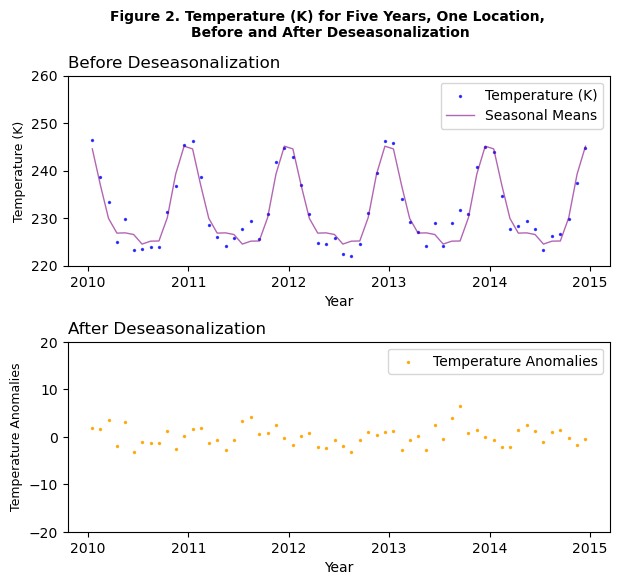

In [31]:
# Filter for 5 years, one point 
FIVE_YEAR_RANGE = slice("2010-01-01", "2014-12-31") 
LATITUDE_n89 = slice(preprocessed_train_step6.latitude[0].values[()])
LONGITUDE_0 = slice(0)
plot_deseas_train_ds = preprocessed_train_step6.sel(time=FIVE_YEAR_RANGE, latitude=LATITUDE_n89, longitude=LONGITUDE_0)
plot_deseas_train_df = plot_deseas_train_ds[['tmp2m', 'deseas_tmp2m', 'seasonal_means_tmp2m']].to_dataframe()
plot_deseas_train_df = plot_deseas_train_df.reset_index()

# Get values needed for plots 
time_values = plot_deseas_train_df['time']
tmp2m_values = plot_deseas_train_df['tmp2m']
seas_means_values = plot_deseas_train_df['seasonal_means_tmp2m']
deseas_tmp2m_values = plot_deseas_train_df['deseas_tmp2m']

# Create plot with subplots
fig, axs = plt.subplots(2, figsize=(7, 6))
fig.suptitle('Figure 2. Temperature (K) for Five Years, One Location, \nBefore and After Deseasonalization', size=10, fontweight='bold')

# Raw data plot 
axs[0].scatter(time_values, tmp2m_values, color='blue', s=2, alpha=0.7, label='Temperature (K)')
axs[0].plot(time_values, seas_means_values, color='purple', linewidth=1, alpha=0.6, label='Seasonal Means')
axs[0].set_ylim(220, 260)
axs[0].set_title("Before Deseasonalization", loc='left')
axs[0].set_xlabel('Year', fontsize=10)
axs[0].set_ylabel('Temperature (K)', fontsize=9)
axs[0].legend()

# Deseasonalized data plot 
axs[1].scatter(time_values, deseas_tmp2m_values, color='orange', s=2, alpha=0.9, label='Temperature Anomalies')
axs[1].set_title("After Deseasonalization", loc='left')
axs[1].set_xlabel('Year', fontsize=10)
axs[1].set_ylabel('Temperature Anomalies', fontsize=9)
axs[1].set_ylim(-20, 20)
axs[1].legend()

# Adjust spacing and show plot 
plt.subplots_adjust(top=0.87, hspace=0.4)
plt.show() 

### 7. Add spatial (and temporal) variables 


**In general:**

This step calls the following functions from `utils.py`:

**`add_polar_coords(ds)`**
- This function takes in a dataset with latitude and longitude dimensions.
- It uses the function `polar_lonlat_to_xy()` from the library [`polar_convert`](https://github.com/nsidc/polarstereo-lonlat-convert-py) to get projected Easting and Northing values using UPS projection. 

**`add_land_sea_mask(ds, filepath)`**
- This function takes in a dataset (`ds`) and the path to a file containing the land sea mask (`filepath`).
- It adds a new data variable `landsfc` which specifies whether the data point is land (=1) or sea (=0). 

**`add_dist_to_coast(ds)`**
- This function takes in a dataset (`ds`) with polar coordinates and land sea mask variables.
- It then calculates the distance from the data point to the coast.
    - Points which correspond to the sea have negative values.
    - units = ??? 

**`add_orogrd(ds, filepath)`**
- This function takes in a dataset (`ds`) and the path to a file containing the orography values (`filepath`).
- It adds a new data variable `oro`, ___ not sure how to describe oro ___ 

**`add_months(ds)`**
- This function takes in a dataset (`ds`), gets the month value from the time dimension, and adds it as a new data variable.
    - January = 1.0, February = 2.0, etc. 

**`add_years(ds)`**
- This function takes in a dataset (`ds`), gets the year value from the time dimension, and adds it as a new data variable.
    - 2010.0 = 2010, 2020 = 2020.0, etc.

--- 

**For this demo:**

The data cells below first get the paths to the additional data files required. It then calls the functions mentioned above to add polar coordinates (Easting and Northing), a land-sea mask, the distance to coast, the orography, the month, and the year. Table 3 summarizes the variables added in this step.  

**Table 3. Summary of Spatial and Temporal Variables Added.**

| Added variable | Description | Method called | Files used | 
|---|---|---|---|
| `E` | Easting Coordinate (Universal Polar Stereographic (UPS) projection) | `add_polar_coords()` | --- | 
| `N` | Northing Coordinate (Universal Polar Stereographic (UPS) projection) | `add_polar_coords()` | --- | 
| `landsfc` | The land sea mask as a boolean (1 = land, 0 = sea) | `add_land_sea_mask()` | 'IsoGSM_land_sea_mask.nc' |
| `dist_to_coast` | Distance to the coast of Antarctica | `add_dist_to_coast()` | --- | 
| `oro` | Orography (a measure of the height of the surface) | `add_orogrd()` | 'IsoGSM_orogrd.nc' | 
| `month` | The month as a float (e.g. January = 1.0) | `add_months()` | --- |
| `year` | The year as a float (e.g. 2020 = 2020.0) | `add_years()` | --- |

We do these steps separately for the train, valid, and test splits. 

In [32]:
############ ENSURE THE PATH BELOW POINTS TO THE RAW DATA 
data_path = 'data/IsoGSM/' 
land_sea_mask_file = data_path + 'IsoGSM_land_sea_mask.nc'
orogrd_file = data_path + 'IsoGSM_orogrd.nc'
#########################################################

In [33]:
# TRAIN 
preprocessed_train_step7 = add_polar_coords(preprocessed_train_step6) # E, N
preprocessed_train_step7 = add_land_sea_mask(preprocessed_train_step7, land_sea_mask_file) # landsfc
preprocessed_train_step7 = add_dist_to_coast(preprocessed_train_step7) # dist_to_coast
preprocessed_train_step7 = add_orogrd(preprocessed_train_step7, orogrd_file) # oro
preprocessed_train_step7 = add_months(preprocessed_train_step7) # month
preprocessed_train_step7 = add_years(preprocessed_train_step7) # year 

In [34]:
# REPEAT FOR VALID AND TEST 
preprocessed_valid_step7 = add_polar_coords(preprocessed_valid_step6) # E, N
preprocessed_valid_step7 = add_land_sea_mask(preprocessed_valid_step7, land_sea_mask_file) # landsfc
preprocessed_valid_step7 = add_dist_to_coast(preprocessed_valid_step7) # dist_to_coast
preprocessed_valid_step7 = add_orogrd(preprocessed_valid_step7, orogrd_file) # oro
preprocessed_valid_step7 = add_months(preprocessed_valid_step7) # month
preprocessed_valid_step7 = add_years(preprocessed_valid_step7) # year 

preprocessed_test_step7 = add_polar_coords(preprocessed_test_step6) # E, N
preprocessed_test_step7 = add_land_sea_mask(preprocessed_test_step7, land_sea_mask_file) # landsfc
preprocessed_test_step7 = add_dist_to_coast(preprocessed_test_step7) # dist_to_coast
preprocessed_test_step7 = add_orogrd(preprocessed_test_step7, orogrd_file) # oro
preprocessed_test_step7 = add_months(preprocessed_test_step7) # month
preprocessed_test_step7 = add_years(preprocessed_test_step7) # year 

**Visual inspection:** 

The following cell shows the additional variables added after step 7.

In [35]:
# Data variables before 
preprocessed_train_step6.data_vars

Data variables:
    d18O_pr                  (time, latitude, longitude) float64 -40.55 ... -...
    hgtprs                   (time, latitude, longitude) float64 5.023e+03 .....
    pratesfc                 (time, latitude, longitude) float64 2.991e-06 .....
    tmp2m                    (time, latitude, longitude) float64 241.3 ... 272.3
    deseas_d18O_pr           (time, latitude, longitude) float64 -1.426 ... 0...
    seasonal_means_d18O_pr   (time, latitude, longitude) float64 -39.13 ... -...
    deseas_hgtprs            (time, latitude, longitude) float64 -86.07 ... -...
    seasonal_means_hgtprs    (time, latitude, longitude) float64 5.109e+03 .....
    deseas_pratesfc          (time, latitude, longitude) float64 2.37e-06 ......
    seasonal_means_pratesfc  (time, latitude, longitude) float64 6.209e-07 .....
    deseas_tmp2m             (time, latitude, longitude) float64 -3.264 ... 0...
    seasonal_means_tmp2m     (time, latitude, longitude) float64 244.6 ... 272.2

In [36]:
# Data variables after 
preprocessed_train_step7.data_vars

Data variables:
    d18O_pr                  (time, latitude, longitude) float64 -40.55 ... -...
    hgtprs                   (time, latitude, longitude) float64 5.023e+03 .....
    pratesfc                 (time, latitude, longitude) float64 2.991e-06 .....
    tmp2m                    (time, latitude, longitude) float64 241.3 ... 272.3
    deseas_d18O_pr           (time, latitude, longitude) float64 -1.426 ... 0...
    seasonal_means_d18O_pr   (time, latitude, longitude) float64 -39.13 ... -...
    deseas_hgtprs            (time, latitude, longitude) float64 -86.07 ... -...
    seasonal_means_hgtprs    (time, latitude, longitude) float64 5.109e+03 .....
    deseas_pratesfc          (time, latitude, longitude) float64 2.37e-06 ......
    seasonal_means_pratesfc  (time, latitude, longitude) float64 6.209e-07 .....
    deseas_tmp2m             (time, latitude, longitude) float64 -3.264 ... 0...
    seasonal_means_tmp2m     (time, latitude, longitude) float64 244.6 ... 272.2
    E       

### 8. Interpolate

**In general:**

Missing values in a dataset can usually be dropped before giving them to ML models. However, due to the gridded nature of xarrays, dropping a NaN for one time, latitude, and longitude coordinate will drop all values that share the time, latitude, and longitude values. Therefore to avoid discarding a lot of data, we can interpolate (or fill in the missing values). 

This step calls the following function from `utils.py`: 

`interpolate_nans(ds, method='smart')`
- This function takes in a dataset with NaN values (`ds`), and a method used to deal with the NaNs.
    - `method='smart'` will perform advanced interpolation.
    - `method='drop'` will simply drop all NaNs from the xarray. 
- The function will first check which variables in `ds` have NaN values.
    - It does this by calling the helper function `percent_nans(flat_tensor)`, which returns the percentage of NaNs. 
- For variables that have a NaN percentage > 0.0, "advanced interpolation" will be performed. 
    - This is done by calling the helper function `interpolate_nans_smart(ds, dims_list, var)`, which implements interpolation using [xarray's Advanced Interpolation tutorial](https://docs.xarray.dev/en/stable/user-guide/interpolation.html#advanced-interpolation).
    - NaNs are interpolated along all three dimenions (time, latitude, longitude). 

--- 

**For this demo:**

The following cell interpolates the missing values using the "smart" method. 

Note that this step is only for training data, not validation or test data. 

In [37]:
# Interpolate with "smart" 
preprocessed_train_step8 = interpolate_nans(preprocessed_train_step7, method='smart')

**Visual inspection:**

The following cells show that before interpolation, there were 24422 NaN values in the training dataset for the variable `d18O_pr`. After interpolation, there are 0 NaNs. 

In [38]:
# NaNs before 
np.isnan(preprocessed_train_step7['d18O_pr'].values).sum()

24422

In [39]:
# NaNs after 
np.isnan(preprocessed_train_step8['d18O_pr'].values).sum()

0

### 9. Scale variables

**In general:**

As variables will differ in units and scale, it is necessary to standardize values to ensure that the ML models will treat features equally during training:

$$v^{scaled}_{lat,lon,month} = \frac{v_{lat,lon,month} - \bar{v}}{\hat{\sigma}} \,\,\,\,\,\,\,\text{(2)}$$

Where 
- $v_{lat,lon,month}$: one of the variables 
- $\bar{v}$: overall mean of one of the variables to be scaled (regardless of latitude, longitude, or month)
- $\hat{\sigma}$: overall standard deviation of one of the variables to be scaled (regardless of latitude, longitude, or month)

This step calls the following class from utils.py:

`XArrayStandardScaler()`

This method is used to standard scale data variables in an xarray. 

- The implementation of this class is inspired by the [Sci-kit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) StandardScaler class (i.e. create and initialize a model, fit to the training data, predict the fitted model on train/valid/test data)
- After initializing an instance of the class, fitting it on the training data, and calling transform, the class will return a new xarray with:
    - The scaled values, named as `scaled_{var_name}`, saved as new data variables. 
    - The computed means and standard deviations of the variables used in the scaling, named as `scaler_mean_{var_name}` and `scaler_stdev_{var_name}`, saved as new attributes. 

--- 

**For this demo:**

The code cells below first make a list of all the variables which will be scaled. Note that the variables "month", "year", and "landsfc" will not be scaled. Then, a scaling object is created by passing in the variables to be scaled. The object is fit on the training data, and then we call `scaler.transform()` to add new scaled variables. 

Note here that when scaling **validation** and **test data**, we use the scaling object that is fit on the training data.  

In [40]:
# TRAIN 
# Create a list of variables to scale 
scale_feats_list = [
        "d18O_pr", "hgtprs", "pratesfc", "tmp2m", 
        "deseas_d18O_pr", "deseas_hgtprs", "deseas_pratesfc", "deseas_tmp2m", 
        "E", "N", "dist_to_coast", "oro"
]
# Initialize the scaling object 
scaler = XArrayStandardScaler(scale_feats = scale_feats_list)

# Fit on training data
scaler.fit(preprocessed_train_step8)

# Transform 
preprocessed_train_step9 = scaler.transform(preprocessed_train_step8)

In [41]:
# REPEAT FOR VALID AND TEST 
preprocessed_valid_step9 = scaler.transform(preprocessed_valid_step7)
preprocessed_test_step9 = scaler.transform(preprocessed_test_step7)

**Visual inspection**

The following cells shows the new scaled variables added after step 9. 

In [42]:
# Data variables before 
preprocessed_train_step8.data_vars

Data variables:
    d18O_pr                  (time, latitude, longitude) float64 -40.55 ... -...
    hgtprs                   (time, latitude, longitude) float64 5.023e+03 .....
    pratesfc                 (time, latitude, longitude) float64 2.991e-06 .....
    tmp2m                    (time, latitude, longitude) float64 241.3 ... 272.3
    deseas_d18O_pr           (time, latitude, longitude) float64 -1.426 ... 0...
    seasonal_means_d18O_pr   (time, latitude, longitude) float64 -39.13 ... -...
    deseas_hgtprs            (time, latitude, longitude) float64 -86.07 ... -...
    seasonal_means_hgtprs    (time, latitude, longitude) float64 5.109e+03 .....
    deseas_pratesfc          (time, latitude, longitude) float64 2.37e-06 ......
    seasonal_means_pratesfc  (time, latitude, longitude) float64 6.209e-07 .....
    deseas_tmp2m             (time, latitude, longitude) float64 -3.264 ... 0...
    seasonal_means_tmp2m     (time, latitude, longitude) float64 244.6 ... 272.2
    E       

In [43]:
# Data variables before 
preprocessed_train_step9.data_vars

Data variables:
    d18O_pr                  (time, latitude, longitude) float64 -40.55 ... -...
    hgtprs                   (time, latitude, longitude) float64 5.023e+03 .....
    pratesfc                 (time, latitude, longitude) float64 2.991e-06 .....
    tmp2m                    (time, latitude, longitude) float64 241.3 ... 272.3
    deseas_d18O_pr           (time, latitude, longitude) float64 -1.426 ... 0...
    seasonal_means_d18O_pr   (time, latitude, longitude) float64 -39.13 ... -...
    deseas_hgtprs            (time, latitude, longitude) float64 -86.07 ... -...
    seasonal_means_hgtprs    (time, latitude, longitude) float64 5.109e+03 .....
    deseas_pratesfc          (time, latitude, longitude) float64 2.37e-06 ......
    seasonal_means_pratesfc  (time, latitude, longitude) float64 6.209e-07 .....
    deseas_tmp2m             (time, latitude, longitude) float64 -3.264 ... 0...
    seasonal_means_tmp2m     (time, latitude, longitude) float64 244.6 ... 272.2
    E       

The following cell shows plots of the temperature anomaly (`deseas_tmp2m`) AND $\delta^{18}O$ anomaly (`d18O_pr`) values for 5 years and one point (latitude=-89, longitude=0) in the training dataset before and after scaling. The y-axes of the four plots have the same range and scale (-20 to 20). 
- The top two plots (before scaling, blue points) show larger amplitudes.
- The bottom two plots (after scaling, orange points) show more flattened points. 

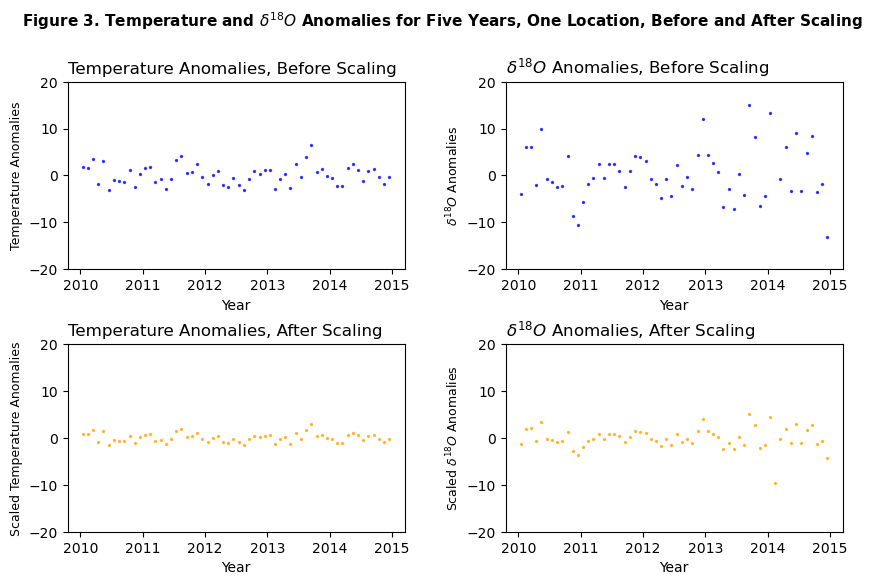

In [44]:
# Filter for 5 years, one point 
FIVE_YEAR_RANGE = slice("2010-01-01", "2014-12-31") 
LATITUDE_n89 = slice(preprocessed_train_step9.latitude[0].values[()])
LONGITUDE_0 = slice(0)
plot_scaled_train_ds = preprocessed_train_step9.sel(time=FIVE_YEAR_RANGE, latitude=LATITUDE_n89, longitude=LONGITUDE_0)
plot_scaled_train_df = plot_scaled_train_ds[['deseas_tmp2m', 'scaled_deseas_tmp2m', 'deseas_d18O_pr', 'scaled_deseas_d18O_pr']].to_dataframe()
plot_scaled_train_df = plot_scaled_train_df.reset_index()

# Get values needed for plots 
time_values = plot_scaled_train_df['time']
deseas_tmp2m_values = plot_scaled_train_df['deseas_tmp2m']
scaled_tmp2m_values = plot_scaled_train_df['scaled_deseas_tmp2m']
deseas_d18O_pr_values = plot_scaled_train_df['deseas_d18O_pr']
scaled_d18O_pr_values = plot_scaled_train_df['scaled_deseas_d18O_pr']

###############

# Create a figure and four subplots arranged in a square
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle('Figure 3. Temperature and $\delta^{18}O$ Anomalies for Five Years, One Location, Before and After Scaling', size=11, fontweight='bold')

# First subplot (top-left) - Deseasonalized temperature  
axes[0, 0].scatter(time_values, deseas_tmp2m_values, color='blue', s=2, alpha=0.7)
axes[0, 0].set_title("Temperature Anomalies, Before Scaling", loc='left')
axes[0, 0].set_xlabel('Year', fontsize=10)
axes[0, 0].set_ylabel('Temperature Anomalies', fontsize=9)
axes[0, 0].set_ylim(-20, 20)

# Second subplot (bottom-left) - Scaled deseasonalized temperature  
axes[1, 0].scatter(time_values, scaled_tmp2m_values, color='orange', s=2, alpha=0.7)
axes[1, 0].set_title("Temperature Anomalies, After Scaling", loc='left')
axes[1, 0].set_xlabel('Year', fontsize=10)
axes[1, 0].set_ylabel('Scaled Temperature Anomalies', fontsize=9)
axes[1, 0].set_ylim(-20, 20)

# Third subplot (top-right) - Deseasonalized delta-18-O
axes[0, 1].scatter(time_values, deseas_d18O_pr_values, color='blue', s=2, alpha=0.7)
axes[0, 1].set_title("$\delta^{18}O$ Anomalies, Before Scaling", loc='left')
axes[0, 1].set_xlabel('Year', fontsize=10)
axes[0, 1].set_ylabel('$\delta^{18}O$ Anomalies', fontsize=9)
axes[0, 1].set_ylim(-20, 20)

# Fourth subplot (bottom-right) - Scaled deseasonalized delta-18-O
axes[1, 1].scatter(time_values, scaled_d18O_pr_values, color='orange', s=2, alpha=0.7)
axes[1, 1].set_title("$\delta^{18}O$ Anomalies, After Scaling", loc='left')
axes[1, 1].set_xlabel('Year', fontsize=10)
axes[1, 1].set_ylabel('Scaled $\delta^{18}O$ Anomalies', fontsize=9)
axes[1, 1].set_ylim(-20, 20)

# Adjust the spacing between subplots
plt.subplots_adjust(top=0.86, hspace=0.4, wspace=0.3)

# Show the figure
plt.show()

### 10. Save preprocessed data

Finally, the following code cell saves the preprocessed training, validation, and test datasets under the `MDS_Antarctica/data/preprocessed/` folder. These will be the inputs for the next steps in the project. 

In [45]:
output_path = 'data/preprocessed/'

In [46]:
# Save preprocessed train, validation, and test data 
preprocessed_train_step9.to_netcdf(output_path + 'preprocessed_train_ds.nc')
preprocessed_valid_step9.to_netcdf(output_path + 'preprocessed_valid_ds.nc')
preprocessed_test_step9.to_netcdf(output_path + 'preprocessed_test_ds.nc')

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\jakob\\Documents\\School\\MDS\\D591\\test\\MDS_Antarctica\\data\\preprocessed\\preprocessed_train_ds.nc'

**Visual inspection**

The following cell should show that the preprocessed files are saved under the `data/preprocessed/` folder.

In [ ]:
!ls data/preprocessed/

preprocessed_test_ds.nc
preprocessed_train_ds.nc
preprocessed_valid_ds.nc
